#library

In [38]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torchvision.models.resnet as resnet

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import numpy as np

#hyperparameter

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)

if device == 'cuda':

    torch.cuda.manual_seed_all(777)

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #normalize는 반드시 ToTensor() 이후에 해야함
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#CIFAR10 dataset

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root = './cifar10', train=True,
                                             download=True, transform = transform_train)

test_dataset = torchvision.datasets.CIFAR10(root = './cifar10', train=False,
                                            download = True, transform = transform_test)

100%|██████████| 170498071/170498071 [00:12<00:00, 13158371.53it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 256,
                                           shuffle = True, num_workers = 0)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256,
                                          shuffle = False, num_workers = 0)

In [6]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

# ResNet

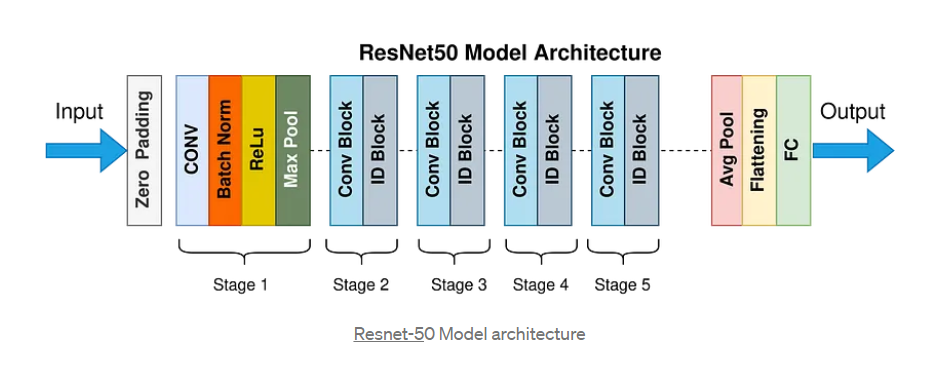

In [7]:
conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock

In [8]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes = 1000, zero_init_residual = False):

        super(ResNet, self).__init__()

        self.inplanes = 16 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 16로 조정

        # inputs = 3x224x224 -> 3x32x32로 바뀜
        # 마찬가지로 전부 사이즈 조정
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3, stride = 1, padding = 1, bias = False)

        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace = True)

        #self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self._make_layer(block, 16, layers[0], stride = 1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride = 1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride = 2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128 * block.expansion,  num_classes)

        for m in self.modules():

            if isinstance(m, nn.Conv2d):

                nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')

            elif isinstance(m, nn.BatchNorm2d):

                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677

        if zero_init_residual:

            for m in self.modules():

                if isinstance(m, Bottleneck):

                    nn.init.constant_(m.bn3.weight, 0)

                elif isinstance(m, BasicBlock):

                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride = 1):

        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:

            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion,  stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes * block.expansion

        for _ in range(1,blocks):

            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        #x.shape =[1, 16, 32,32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        #x.shape =[1, 128, 32,32]
        x = self.layer2(x)
        #x.shape =[1, 256, 32,32]
        x = self.layer3(x)
        #x.shape =[1, 512, 16,16]
        x = self.layer4(x)
        #x.shape =[1, 1024, 8,8]

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [ ]:
resnet50 = ResNet(resnet.Bottleneck, [3,4,6,3], 10, True)

resnet50.to(device)

In [25]:
# 출력 tensor가 맞는지 확인해보자

from torchsummary import summary
summary(resnet50, input_size=(3, 32,32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             256
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]           1,024
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]           1,024
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [28]:
a = train_dataset[0][0].to(device)

out = resnet50(a.unsqueeze(0))

print(out)

tensor([[-0.3011, -0.3660,  0.4414, -0.1238,  0.4686,  0.0792,  0.2027, -0.0958,
          0.0766,  0.0230]], device='cuda:0', grad_fn=<AddmmBackward0>)


# filter visualization

https://github.com/inhovation97/Image_classification_pipeline_Project/blob/main/pytorch/pytorch_project_resnet50.ipynb

In [43]:
def imshow(img):

    img = img/2 + 0.5

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

torch.Size([16, 3, 3, 3])


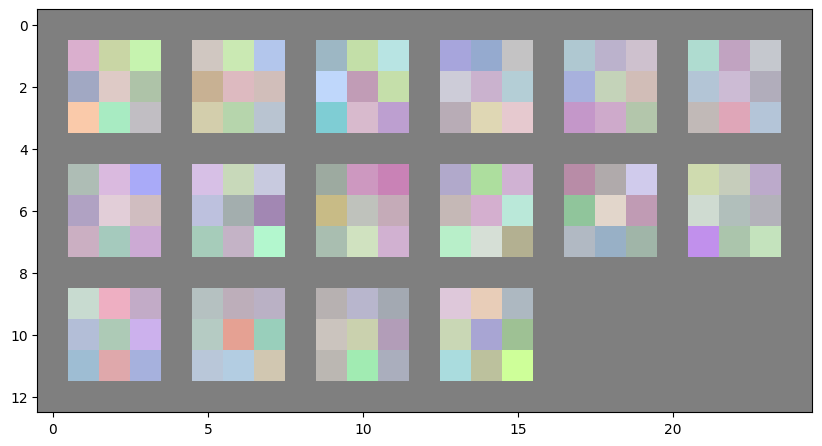

In [44]:
# 첫번째 layer의 filter

for w in resnet50.parameters():

    w = w.data.cpu()
    print(w.shape)
    break

#renomalization

min_w = torch.min(w)
w1 = (-1/(2*min_w)) * w + 0.5

#make grid to display it

grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow = 6, padding = 1)

plt.figure(figsize = (10,10))
imshow(x_grid)

#training

In [45]:
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 5e-4)

lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

In [46]:
epochs = 10

resnet50.train()

for epoch in tqdm(range(epochs)):

    running_loss = 0.0
    lr_sche.step()

    for i,data in enumerate(tqdm(train_loader)):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % 30 == 29: #print every 30 mini-batches

            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 30))

            running_loss = 0.0

print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/196 [00:00<?, ?it/s]

[1,    30] loss: 2.060
[1,    60] loss: 1.870
[1,    90] loss: 1.798
[1,   120] loss: 1.711
[1,   150] loss: 1.637
[1,   180] loss: 1.590


  0%|          | 0/196 [00:00<?, ?it/s]

[2,    30] loss: 1.526
[2,    60] loss: 1.472
[2,    90] loss: 1.394
[2,   120] loss: 1.350
[2,   150] loss: 1.289
[2,   180] loss: 1.232


  0%|          | 0/196 [00:00<?, ?it/s]

[3,    30] loss: 1.186
[3,    60] loss: 1.129
[3,    90] loss: 1.109
[3,   120] loss: 1.071
[3,   150] loss: 1.038
[3,   180] loss: 1.025


  0%|          | 0/196 [00:00<?, ?it/s]

[4,    30] loss: 1.001
[4,    60] loss: 0.955
[4,    90] loss: 0.955
[4,   120] loss: 0.942
[4,   150] loss: 0.953
[4,   180] loss: 0.928


  0%|          | 0/196 [00:00<?, ?it/s]

[5,    30] loss: 0.864
[5,    60] loss: 0.845
[5,    90] loss: 0.866
[5,   120] loss: 0.838
[5,   150] loss: 0.862
[5,   180] loss: 0.849


  0%|          | 0/196 [00:00<?, ?it/s]

[6,    30] loss: 0.807
[6,    60] loss: 0.767
[6,    90] loss: 0.771
[6,   120] loss: 0.782
[6,   150] loss: 0.754
[6,   180] loss: 0.753


  0%|          | 0/196 [00:00<?, ?it/s]

[7,    30] loss: 0.741
[7,    60] loss: 0.692
[7,    90] loss: 0.713
[7,   120] loss: 0.678
[7,   150] loss: 0.660
[7,   180] loss: 0.681


  0%|          | 0/196 [00:00<?, ?it/s]

[8,    30] loss: 0.659
[8,    60] loss: 0.633
[8,    90] loss: 0.638
[8,   120] loss: 0.624
[8,   150] loss: 0.600
[8,   180] loss: 0.607


  0%|          | 0/196 [00:00<?, ?it/s]

[9,    30] loss: 0.604
[9,    60] loss: 0.571
[9,    90] loss: 0.577
[9,   120] loss: 0.587
[9,   150] loss: 0.593
[9,   180] loss: 0.592


  0%|          | 0/196 [00:00<?, ?it/s]

[10,    30] loss: 0.487
[10,    60] loss: 0.433
[10,    90] loss: 0.446
[10,   120] loss: 0.463
[10,   150] loss: 0.455
[10,   180] loss: 0.458
Finished Training


# test

In [47]:
resnet50.eval()

correct = 0
total = 0

with torch.no_grad():

    for data in tqdm(test_loader):

        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)

        _, predicted = torch.max(outputs.data,1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = (100*correct/total)

    print('accuracy of the network on the 10000 test images: %d %%' %acc)

    torch.save(resnet50.state_dict(), './model_epoch_{}_acc_{}.pth'.format(epoch,int(acc)))

print(acc)

  0%|          | 0/40 [00:00<?, ?it/s]

accuracy of the network on the 10000 test images: 79 %
79.39


torch.Size([16, 3, 3, 3])


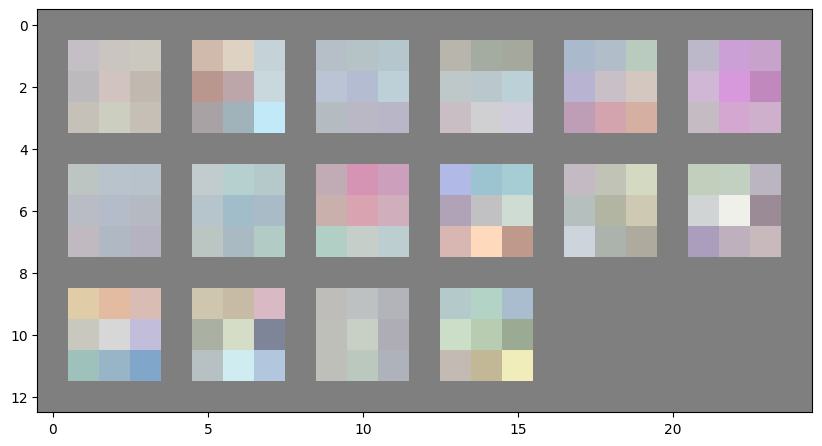

In [48]:
# 훈련된 첫번째 layer의 filter

for w in resnet50.parameters():

    w = w.data.cpu()
    print(w.shape)
    break

#renomalization

min_w = torch.min(w)
w1 = (-1/(2*min_w)) * w + 0.5

#make grid to display it

grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow = 6, padding = 1)

plt.figure(figsize = (10,10))
imshow(x_grid)